In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import torch

from torchvision import transforms, models
from torchvision.datasets import CIFAR10, CIFAR100

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import pandas as pd
import tqdm

from safe_region_counters import WholeMinMax, LayerMinMax, SafeRegion
from utils import (
    add_hooks, run_counter, add_safe_results, plot_prob_res, plot_minmax,
    quick_train
)

In [3]:
cifar10 = CIFAR10('/data/benjamin.pikus', download=True,
    transform=transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))

Files already downloaded and verified


In [99]:
cifar100 = CIFAR100('/data/benjamin.pikus', download=True,
    transform=transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))

Extracting /data/benjamin.pikus/cifar-100-python.tar.gz to /data/benjamin.pikus


In [4]:
cifar10_train, cifar10_test = torch.utils.data.random_split(
    cifar10, [int(len(cifar10)*0.8),int(len(cifar10)*0.2)], generator =torch.Generator().manual_seed(50))
#cifar100_train, cifar100_test = torch.utils.data.random_split(
#    cifar100, [int(len(cifar100)/2),int(len(cifar100)/2)], generator =torch.Generator().manual_seed(50))

In [5]:
resnet18_trained = models.resnet18(pretrained=True)
resnet18_untrained = models.resnet18(pretrained=False)

In [8]:
quick_train(cifar10_train,resnet18_trained, num_epochs = 3, num_classes = len(cifar10.classes))

Loss 0/3 = 0.00962290490269661
Loss 1/3 = 0.006116467772424221
Loss 2/3 = 0.005484181821346283


In [9]:
all_handlers = {
    "WholeMinMax:-0.9" :  WholeMinMax(-0.9),
    "WholeMinMax:0" : WholeMinMax(0),
    "WholeMinMax:0.9" : WholeMinMax(0.9),
    "LayerMinMax:-0.2" :  LayerMinMax(-0.2),
    "LayerMinMax:0" : LayerMinMax(0),
    "LayerMinMax:0.2" : LayerMinMax(0.2),
    "LayerMinMax:0.5" : LayerMinMax(0.5),
}

In [39]:
all_handlers["WholeMinMax:-0.9"].count_safe.keys()

dict_keys(['relu', 'layer1.0.relu', 'layer1.1.relu', 'layer2.0.relu', 'layer2.1.relu', 'layer3.0.relu', 'layer3.1.relu', 'layer4.0.relu', 'layer4.1.relu', 'layer2.0', 'layer2.0_relu'])

In [44]:
(all_handlers["LayerMinMax:-0.2"].count_notsafe['layer2.0.relu'])

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [10]:
for h in all_handlers.values():
    add_hooks(resnet18_trained, h)
    #add_hooks(resnet18_untrained, h)

In [25]:
run_counter(resnet18_trained, cifar10_train, list(all_handlers.values()), train=True, adversarial = False)

100%|██████████| 313/313 [01:36<00:00,  3.23it/s]


(tensor(99.7572, device='cuda:0'), 0.0)

In [28]:
run_counter(resnet18_trained, cifar10_test, list(all_handlers.values()), train=False, adversarial = True)

100%|██████████| 79/79 [01:45<00:00,  1.33s/it]


(98.49367088607595, 47.822784810126585)

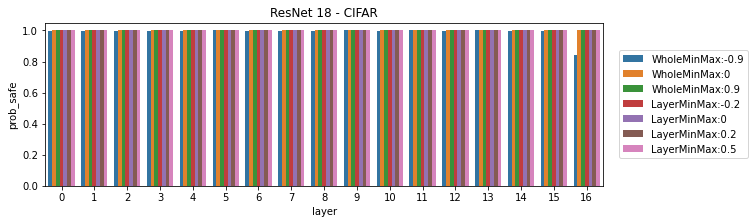

In [30]:
# Plot Results
prob_safe_df = pd.DataFrame()
for k,v in all_handlers.items():
    prob_safe_df[k] = add_safe_results(v)
plot_prob_res(prob_safe_df, 'ResNet 18 - CIFAR')

In [31]:
prob_safe_df

,WholeMinMax:-0.9,WholeMinMax:0,WholeMinMax:0.9,LayerMinMax:-0.2,LayerMinMax:0,LayerMinMax:0.2,LayerMinMax:0.5,layer
0,0.999703,1.0,1.0,1.0,1.0,1.0,1.0,0
1,0.995544,1.0,1.0,1.0,1.0,1.0,1.0,1
2,0.998368,1.0,1.0,1.0,1.0,1.0,1.0,2
3,0.998962,1.0,1.0,1.0,1.0,1.0,1.0,3
4,0.997600,1.0,1.0,1.0,1.0,1.0,1.0,4
5,0.999915,1.0,1.0,1.0,1.0,1.0,1.0,5
6,0.998891,1.0,1.0,1.0,1.0,1.0,1.0,6
7,0.999825,1.0,1.0,1.0,1.0,1.0,1.0,7
8,0.999279,1.0,1.0,1.0,1.0,1.0,1.0,8
9,0.999976,1.0,1.0,1.0,1.0,1.0,1.0,9


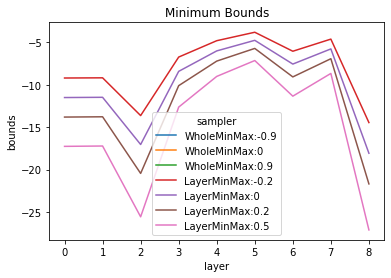

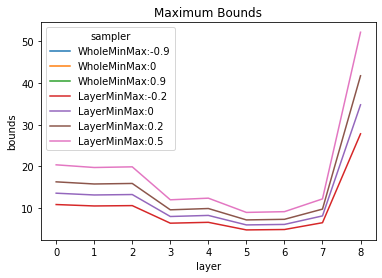

In [32]:
plot_minmax(all_handlers)